## Recurrent Neural Networks for Time Series
- We aim to cover simple RNN, LSTM and GRUs. 


In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Obtaining real data 
- Here we show how to get real datasets from the `statsmodel` library to test your models on data which is not synthetic. This will test your models on datasets which are "less nice".
- The data being loaded will produce *pandas dataframes*, so we'll cover the basics of how to treat these objects.
- You can have a look at all the available datasets in https://vincentarelbundock.github.io/Rdatasets/articles/data.html . This will have a table explaining the datasets. These come from different R packages, and then inside each package there is a set of datasets. Below we specify that we want the USMacroSW dataset found in the AER package.

In [ ]:
# sm.datasets.get_rdataset creates an object, and the .data atribute contains the data
us_macroeconomic_data = sm.datasets.get_rdataset("USMacroG", "AER").data 
# Get timeline for the dataset
dates = pd.date_range("01-01-1950", freq ="QS", periods=us_macroeconomic_data.shape[0])
data = us_macroeconomic_data.set_index(dates)

This data covers quaterly macroeconomic data (GDP, consumption, unemployment, inflation, etc) for the US from 1950 to 2000.

In [4]:
data.head()

,gdp,consumption,invest,government,dpi,cpi,m1,tbill,unemp,population,inflation,interest
1950-01-01,1610.5,1058.9,198.1,361.0,1186.1,70.6,110.20,1.12,6.4,149.461,NaN,NaN
1950-04-01,1658.8,1075.9,220.4,366.4,1178.1,71.4,111.75,1.17,5.6,150.260,4.5071,-3.3404
1950-07-01,1723.0,1131.0,239.7,359.6,1196.5,73.2,112.95,1.23,4.6,151.064,9.9590,-8.7290
1950-10-01,1753.9,1097.6,271.8,382.5,1210.0,74.9,113.93,1.35,4.2,151.871,9.1834,-7.8301
1951-01-01,1773.5,1122.8,242.9,421.9,1207.9,77.3,115.08,1.40,3.5,152.393,12.6160,-11.2160


##### Brief intro to pandas (expand later)
- The main purpose of the pandas library is to use pd.DataFrame objects, which creates 2D arrays. This is useful for data processing.

| What I would like to do                 | How to do it |
| ---                                     | ---          |
| Select columns                          | You can either do `data.columnName`, eg: data.gdp or you can access them by doing `data["columnName"]` |
| Select rows                             | You can pass a slice to select the desired rows, eg. `data[0:3]` selects the first three rows |
| Select columns and rows by *labels*     | You need to use `.loc`, for example `data.loc["1950-01-01":"1955-01-01",["gdp", "cpi"]]` selects the first 5 years and only the gdp and cpi columns |
| Select columns and rows by *location*   | Similarly to above but now we do `data.iloc[0:3,4:5]` |

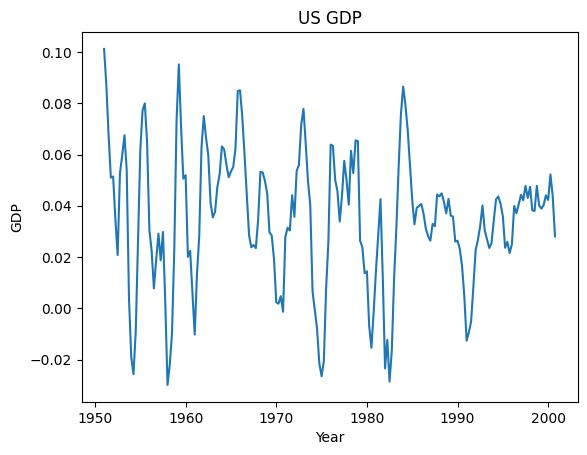

In [5]:
# Let's get the time series data we want
# gdp is the year on year percentage change in GDP
gdp = data["gdp"].pct_change(periods=4).to_numpy()
plt.plot(dates, gdp)
plt.title("US GDP")
plt.xlabel("Year")
plt.ylabel("GDP")
plt.show()

##### Taking NaNs out
Entries with NaN will mess up the code so we take it out. It turns out that it's only in the first row, so it's easy to deal with.

In [4]:
nan_count = data.isna().sum().sum()
print(f'Total number of NaN values in the data: {nan_count}')

Total number of NaN values in the data: 2


In [5]:
data = data[1:]

### Preparing the data
We have to do a few things: 
- Go through all the mess of preparing training and testing datasets in with PyTorch tensors to input into our RNN. 
- Now we are working with real multivariate data. This means that each time series works on a different scale. We should hence normalise the data. Some reasons: 
<br> (1) Improves converges by ensuring that all features contribute the same to the loss. 
<br> (2) Prevents exploding gradients, as large features can lead to large gradients which will generate instability during training. 
<br> (3) Makes features comparable so that they are treated equally by the model. 

A word about broadcasting:
- Notice that to normalise we are using broadcasting, which is a technique in which we allow operations between tensors of different dimensions by automatically expanding the necessary dimensions. For example, below we have the X_train dataset with shape (172, 10, 12). When we do the mean across every time series for every feature, we get a mean vector with shape (12,). When we subtract one from the other, we expand behind the scene the dimension of the mean vector to (172, 10, 12). 

In [31]:
def prepare_data(data):
        
        p = 10  # Past window size
        h = 1   # Forecast horizon
        T = data.shape[0]
        testing_length = round(T/10)
        input_size = data.shape[1]

        # Prepare input-output pairs using sliding window
        X_train, Y_train, X_test, Y_test = [], [], [], []

        for t in range(T - p - h- testing_length):  # Make sure we have enough room for input and target
                X_train.append(data.iloc[t:t + p])  # Past p steps
                Y_train.append(data.iloc[t + p + h - 1])  # Future value at step t + p + h
        for t in range(T - p - h- testing_length, T - p - h):  # Testing data
                X_test.append(data.iloc[t:t + p])  # Past p steps
                Y_test.append(data.iloc[t + p + h - 1])  # Future value at step t + p + h


        # Convert to numpy arrays
        X_train = np.array(X_train).reshape(-1, p, input_size)  # Reshape to (num_samples, p, input_size)
        Y_train = np.array(Y_train).reshape(-1, input_size)  # Reshape to (num_samples, input_size)
        X_test = np.array(X_test).reshape(-1, p, input_size)  # Reshape to (num_samples, p, input_size)
        Y_test = np.array(Y_test).reshape(-1, input_size)    # Reshape to (num_samples, input_size)

        # Compute mean and standard deviation across the entire training dataset
        mean_train_x = X_train.mean(axis=(0,1))
        std_train_x = X_train.std(axis=(0,1))
        mean_train_y = Y_train.mean(axis=0)
        std_train_y = Y_train.std(axis=0)

        # Normalize using the same mean and std for training and testing
        X_train = (X_train - mean_train_x) / std_train_x
        X_test = (X_test - mean_train_x) / std_train_x
        Y_train = (Y_train - mean_train_y) / std_train_y
        # Notice how we don't normalize the test set, we'll denormalise our predictions later

        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

        # Create DataLoader for batching
        batch_size = 32
        training_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
        testing_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
        training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
        testing_dataloader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

        return training_dataloader, testing_dataloader, mean_train_x, std_train_x, mean_train_y, std_train_y

training_dataloader, testing_dataloader, mean_train_x, std_train_x, mean_train_y, std_train_y = prepare_data(data)

### A Simple Recurrent Neural Network model
Let's quickly cover the architecture of a vanilla RNN. This is a function $$f_\theta : (x_t,h_t) \rightarrow (y_t,h_{t+1})$$ where 
<br>(1) $x_t$ is the input vector
<br>(2) $y_t$ is the output vector 
<br>(3) $h_t$ is a vector which acts as a long term memory of what has been inputted before


\begin{align*}
& h_t = \tanh (W_hh_{t-1}+ W_xx_t+b_h) \\
& y_t = W_yh_t + b_y
\end{align*}

In [23]:
class vanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(vanillaRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Recall that linear layers include biases so no need to include b_h, b_y
        self.Wh = nn.Linear(self.hidden_size, self.hidden_size)
        self.Wx = nn.Linear(self.input_size, self.hidden_size)
        self.Wy = nn.Linear(self.hidden_size, self.output_size)

    def forward(self,x):
        # x shape: (batch_size, seq_len, input_size)
        #           batch_size = number of samples of time series in a batch
        #           seq_len = number of time steps in each sample
        #           input_size = number of features in each time step
        batch_size, seq_len, _ = x.size()

        # Notice that we are processing all elements of the batch at the same time
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        for t in range(seq_len):
            x_t = x[:, t, :]  # shape: (batch_size, input_size)
            h_t = torch.tanh(self.Wx(x_t) + self.Wh(h_t))

        # Output from the final hidden state
        out = self.Wy(h_t)
        return out

In [24]:
# Recall input_size = data.shape[1]
output_size, input_size = data.shape[1], data.shape[1]
model = vanillaRNN(input_size, 16, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 300
for epoch in range(num_epochs):
    for _, (X_batch, Y_batch) in enumerate(training_dataloader):
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 30 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [30/300], Loss: 0.0781
Epoch [60/300], Loss: 0.0904
Epoch [90/300], Loss: 0.0633
Epoch [120/300], Loss: 0.0857
Epoch [150/300], Loss: 0.0303
Epoch [180/300], Loss: 0.0220
Epoch [210/300], Loss: 0.0609
Epoch [240/300], Loss: 0.0232
Epoch [270/300], Loss: 0.0318
Epoch [300/300], Loss: 0.0206


### Testing specific components

In [25]:
model.eval()  # Set the model to evaluation mode
predictions = []
actuals = []

with torch.no_grad():
    for (X_batch, Y_batch) in testing_dataloader:
        prediction = model(X_batch)* std_train_y + mean_train_y  # Denormalize predictions
        predictions.append(prediction.numpy())
        actuals.append(Y_batch.numpy())

# Concatenate predictions and actuals for plotting
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)


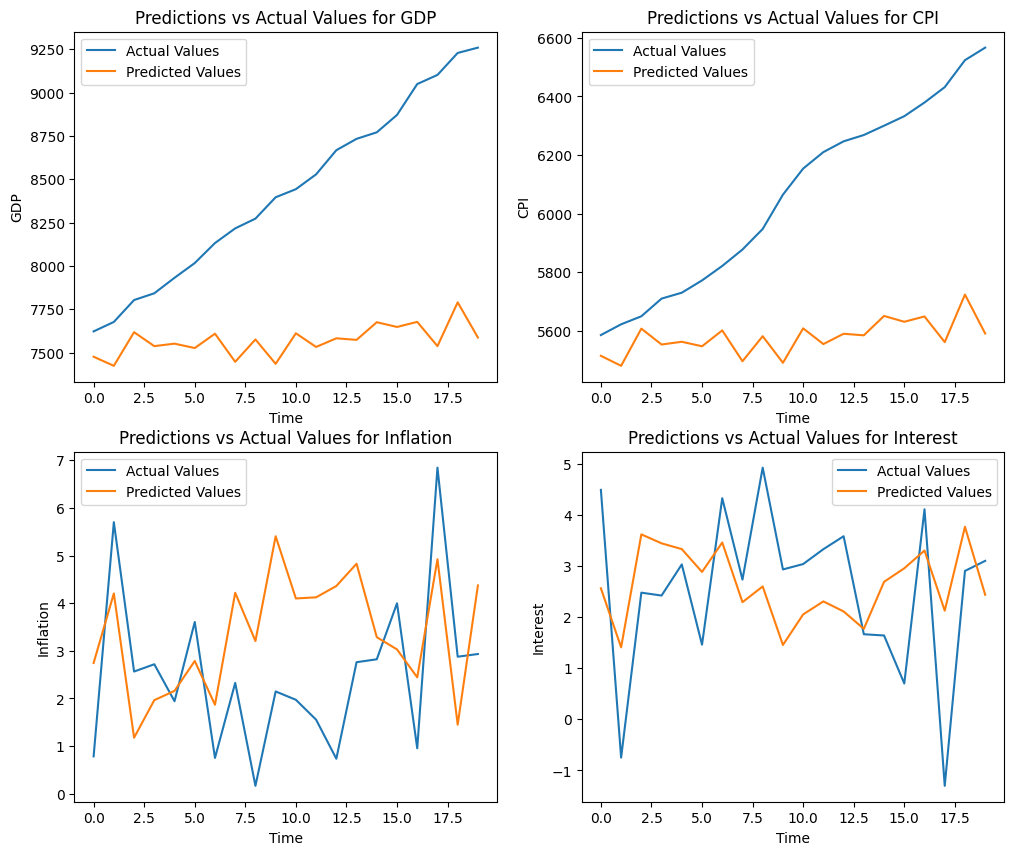

In [26]:
fig, axis = plt.subplots(2, 2, figsize=(12, 10))  # 2 row, 2 columns

axis[0,0].plot(actuals[:, 0], label='Actual Values')
axis[0,0].plot(predictions[:, 0], label='Predicted Values')
axis[0,0].set_title("Predictions vs Actual Values for GDP")
axis[0,0].set_xlabel("Time")
axis[0,0].set_ylabel("GDP")
axis[0,0].legend()

axis[0,1].plot(actuals[:, 4], label='Actual Values') 
axis[0,1].plot(predictions[:, 4], label='Predicted Values')
axis[0,1].set_title("Predictions vs Actual Values for CPI")
axis[0,1].set_xlabel("Time")
axis[0,1].set_ylabel("CPI")
axis[0,1].legend()

axis[1,0].plot(actuals[:, 10], label='Actual Values') 
axis[1,0].plot(predictions[:, 10], label='Predicted Values')
axis[1,0].set_title("Predictions vs Actual Values for Inflation")
axis[1,0].set_xlabel("Time")
axis[1,0].set_ylabel("Inflation")
axis[1,0].legend()

axis[1,1].plot(actuals[:, 11], label='Actual Values') 
axis[1,1].plot(predictions[:, 11], label='Predicted Values')
axis[1,1].set_title("Predictions vs Actual Values for Interest")
axis[1,1].set_xlabel("Time")
axis[1,1].set_ylabel("Interest")
axis[1,1].legend()

plt.show()

### Key takeaways
- Normalisation is vital to ensure good model performance. 
- With very small datasets like this one, ie. only 172 individual fragments when $p=10$, it's important to avoid overfitting. So don't use too many epochs and adjust the learning rate accordingly. 

Some aspects to explore:
- The models seems to capture some of the seasonality in the data, but fails at extracting the trend of some features like GDP.
- Let's see what happens when we fit an RNN explicitly only with GDP data. Will it pick up the trend?

In [36]:
model = vanillaRNN(1, 16, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 300
for epoch in range(num_epochs):
    for _, (X_batch, Y_batch) in enumerate(training_dataloader):
        # Forward pass
        CPI_X_batch = X_batch[:, :, 0].unsqueeze(-1)
        CPI_Y_batch = Y_batch[:, 0].unsqueeze(-1)
        outputs = model(CPI_X_batch)
        loss = criterion(outputs, CPI_Y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 30 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [30/300], Loss: 0.0016
Epoch [60/300], Loss: 0.0013
Epoch [90/300], Loss: 0.0018
Epoch [120/300], Loss: 0.0006
Epoch [150/300], Loss: 0.0013
Epoch [180/300], Loss: 0.0007
Epoch [210/300], Loss: 0.0023
Epoch [240/300], Loss: 0.0006
Epoch [270/300], Loss: 0.0002
Epoch [300/300], Loss: 0.0003


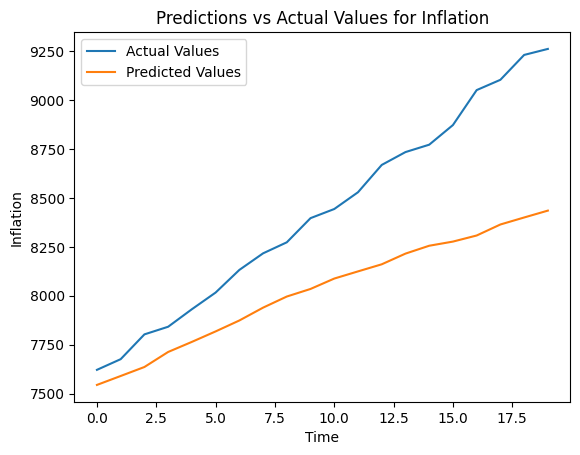

In [40]:
model.eval()  # Set the model to evaluation mode
predictions = []
actuals = []

with torch.no_grad():
    for (X_batch, Y_batch) in testing_dataloader:
        CPI_X_batch = X_batch[:, :, 0].unsqueeze(-1)
        CPI_Y_batch = Y_batch[:, 0].unsqueeze(-1)
        prediction = model(CPI_X_batch)* std_train_y + mean_train_y
        predictions.append(prediction.numpy())
        actuals.append(CPI_Y_batch.numpy())

# Concatenate predictions and actuals for plotting
predictions = np.concatenate(predictions, axis=0)[:,0]
actuals = np.concatenate(actuals, axis=0)

# Plot predictions vs actual values
plt.plot(actuals, label='Actual Values')
plt.plot(predictions, label='Predicted Values')
plt.title("Predictions vs Actual Values for Inflation")
plt.xlabel("Time")
plt.ylabel("Inflation")
plt.legend()
plt.show()


Hurray! The model does pick up the trend now. It's still not great, but at least we have an intuition as to why it's happening: not all features show a trend, eg. inflation, so the model fails at picking this up. Interestingly, when we fit the model with unnormalised data, we see the opposite: all predictions show a strong trend. This is due to the fact that GDP is huge in comparison to other features, so the model picks up its trend and applies it to the rest.

### Pre-built RNN layers
Here we built an RNN from scratch. However, PyTorch has already built in RNN layers! Let's quickly show how it works:

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

### LSTM Model
LSTM stands for Long-Short Term Memory. The idea is simple: in the vanilla RNN we had only one hidden state $h_t$ which was supposed to act as a memory and as an output vector. But we only had one vector to do both things. Here we use two different vectors and control the flow of information more carefully.

Now we have two different memories:
<br>(1) **Memory state:** $c_t$, although in most places it's called the *cell-state*
<br>(2) **Output:** $h_t$, this is what we call the hidden state. It controls the short memory and will ultimately decide what to output. 

Hence, the idea is very simple. We'll loop like we did before, incorporating new data at each step. This will modify the long term memory and the output. 

We control the flow of information through *gates*. There are two gates which control the memory:
<br>(1) **Forget gate** $f_t$: decides what to erase from long-term memory:
$$f_t = \sigma(W_{fh}h_{t-1} + W_{fx}x_t+b_f)$$
<br>(2) **Input gate** $i_t$: decides what to input to the long-term memory: 
$$i_t = \sigma(W_{ih}h_{t-1} + W_{ix}x_t+b_i)$$

So how is memory updated? First we create a candidate memory:
$$\tilde{c_t} = \tanh(W_{ch}h_{t-1} + W_{cx}x_t +b_c),$$
and then we use the gates to decide how much of the old memory to keep and how much to update it:
$$ c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c_t} $$

Finally, the **output gate** controls what to take from the memory:
$$ o_t = \sigma(W_{oh}h_{t-1} + W_{ox}x_t + b_o)$$
and 
$$h_t = o_t \odot \tanh(c_t)$$

In [32]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.LSTM = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)

        # LSTM outputs output state at each element of the loop (out) and hidden states (_)
        out, _ = self.LSTM(x)
        # We are only interested in the last output state
        # out[:,-1,:] shape: (batch_size, output_size)
        out = self.linear(out[:, -1, :])
        return out

In [33]:
model2 = LSTM(input_size=12, hidden_size=50, output_size=12)
loss = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.0007)
num_epochs = 300

for epoch in range(num_epochs):
    for i, (x_batch, y_batch) in enumerate(training_dataloader):
        # Forward pass
        outputs = model2(x_batch)
        loss_value = loss(outputs, y_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

    if (epoch + 1) % 30 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_value.item():.4f}')

Epoch [30/300], Loss: 0.1575
Epoch [60/300], Loss: 0.1081
Epoch [90/300], Loss: 0.1121
Epoch [120/300], Loss: 0.0403
Epoch [150/300], Loss: 0.0562
Epoch [180/300], Loss: 0.0659
Epoch [210/300], Loss: 0.0526
Epoch [240/300], Loss: 0.0508
Epoch [270/300], Loss: 0.0264
Epoch [300/300], Loss: 0.0447


In [34]:
model.eval()  # Set the model to evaluation mode
predictions = []
actuals = []

with torch.no_grad():
    for (X_batch, Y_batch) in testing_dataloader:
        prediction = model(X_batch)* std_train_y + mean_train_y  # Denormalize predictions
        predictions.append(prediction.numpy())
        actuals.append(Y_batch.numpy())

# Concatenate predictions and actuals for plotting
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)


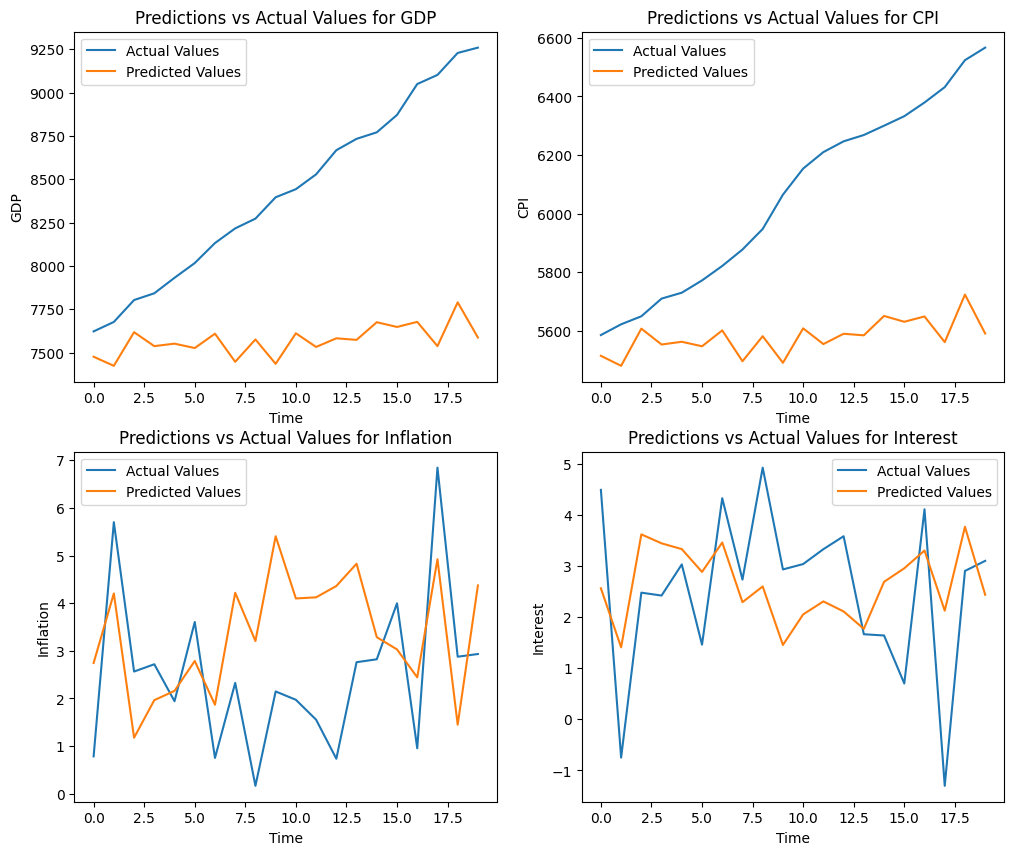

In [35]:
fig, axis = plt.subplots(2, 2, figsize=(12, 10))  # 2 row, 2 columns

axis[0,0].plot(actuals[:, 0], label='Actual Values')
axis[0,0].plot(predictions[:, 0], label='Predicted Values')
axis[0,0].set_title("Predictions vs Actual Values for GDP")
axis[0,0].set_xlabel("Time")
axis[0,0].set_ylabel("GDP")
axis[0,0].legend()

axis[0,1].plot(actuals[:, 4], label='Actual Values') 
axis[0,1].plot(predictions[:, 4], label='Predicted Values')
axis[0,1].set_title("Predictions vs Actual Values for CPI")
axis[0,1].set_xlabel("Time")
axis[0,1].set_ylabel("CPI")
axis[0,1].legend()

axis[1,0].plot(actuals[:, 10], label='Actual Values') 
axis[1,0].plot(predictions[:, 10], label='Predicted Values')
axis[1,0].set_title("Predictions vs Actual Values for Inflation")
axis[1,0].set_xlabel("Time")
axis[1,0].set_ylabel("Inflation")
axis[1,0].legend()

axis[1,1].plot(actuals[:, 11], label='Actual Values') 
axis[1,1].plot(predictions[:, 11], label='Predicted Values')
axis[1,1].set_title("Predictions vs Actual Values for Interest")
axis[1,1].set_xlabel("Time")
axis[1,1].set_ylabel("Interest")
axis[1,1].legend()

plt.show()

### The GRU Model
The Gated Recurrent Unit architecture is a model in between the LSTM discussed, and the vanilla RNN. It only has one hidden unit (like in the vanilla RNN) but uses two gates to update the information stored by the hidden unit in a similar way to the LSTM. \\

As usual, denote by $x_t$ the input at time $t$ and $h_t$ the hidden state at that same time. \\

A **reset gate** is used to control how much information to forget:

$$r_t = \sigma (W_{rx}x_t + W_{rh}h_{t-1}+b_r).$$

With this reset gate, we propose a **candidate hidden state** $\tilde{h}_t$:
$$ \tilde{h}_t = \tanh (W_{hx}x_t + W_{hh}(r_t\odot h_{t-1})+b_h ) $$

Finally, we use an **udpdate gate** to select how much we decide to update the hidden state with the candidate cell, ie:
$$z_t = \sigma (W_{zx}x_t + W_{zh}h_{t-1}+b_z)$$
and hence
$$h_t = (1-z_t)\odot h_{t-1} + z_t\odot \tilde{h}_t.$$

In [3]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.GRU = nn.GRU(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)

        # GRU outputs output state at each element of the loop (out) and hidden states (_)
        out, _ = self.GRU(x)
        # We are only interested in the last output state
        # out[:,-1,:] shape: (batch_size, output_size)
        out = self.linear(out[:, -1, :])
        return out